In [1]:
#imports
import astropy.units as u
import numpy as np
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic
from astropy.coordinates import SkyCoord, Distance
#import popsims
import matplotlib.pyplot as plt
#%matplotlib notebook
from tqdm import tqdm
from astropy.constants import G
import HSS
from gala.units import galactic
import gala.coordinates as gc
import  h5py
import imageio
import seaborn as sns
import matplotlib as mpl
import matplotlib.animation as animation
import astropy.coordinates as astro_coord
sns.set_style("dark")
mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16) 
font = {#'family' : 'Helvetica',
        'size'   : 16}

from shapey import Box
#plt.style.use('dark_background')
%matplotlib inline

In [2]:
def plot_stream(mock_st, mock_pos, filename='palomar_5_1Gyr.jpeg', alpha=0.5):
    #visualize 
    fig, (ax, ax1)=plt.subplots(figsize=(12, 4), ncols=2)

    ax.scatter(mock_st.x, \
               mock_st.y,  s=1, alpha=alpha, c='k')
    ax.scatter(mock_pos.x, mock_pos.y, s=100, c='r')
    ax.set_xlabel('x (kpc)', fontsize=16)
    ax.set_ylabel('y (kpc)', fontsize=16)

    ax1.scatter(mock_icrs.ra, \
               mock_icrs.dec,  s=1, alpha=alpha, c='k')
    ax1.scatter(mock_pos.to_coord_frame(astro_coord.ICRS).ra, \
                mock_pos.to_coord_frame(astro_coord.ICRS).dec, s=100, c='r')

    ax1.set_xlabel('ra (deg)', fontsize=16)
    ax1.set_ylabel('dec (deg)', fontsize=16)
    ax1.invert_xaxis()
    #ax.set(xlim=[245, 255], ylim=[-10, 2.5])
    plt.tight_layout()
    plt.savefig(path_plot +filename)

In [3]:
path_plot = '/users/caganze/research/stellarstreams/figures/palomar5/'
path_data = '/users/caganze/research/stellarstreams/data/'
_ = astro_coord.galactocentric_frame_defaults.set('v4.0')
pot=gp.MilkyWayPotential()
H = gp.Hamiltonian(pot)

In [4]:
coord=SkyCoord(ra=229.02*u.degree, dec=-0.11138*u.degree,  unit=(u.hourangle, u.deg), 
               pm_ra_cosdec=-2.75*u.mas/u.yr, pm_dec=-2.69*u.mas/u.yr, distance=21*u.kpc, 
              radial_velocity= -57.4*u.km/u.s)

In [5]:
v_sun = astro_coord.CartesianDifferential([11.1, 220 + 24.0, 7.25]*u.km/u.s)
galcen_frame =astro_coord.Galactocentric(galcen_distance=8.*u.kpc,
                                    galcen_v_sun=v_sun)

In [6]:
st_pos=gd.PhaseSpacePosition(coord.transform_to(galcen_frame).cartesian)

In [7]:
#pick a subhalo and integrate it back
pal5=gp.Hamiltonian(pot).integrate_orbit(st_pos, dt=1*u.Myr, t1=0*u.Gyr, t2=10.*u.Gyr)

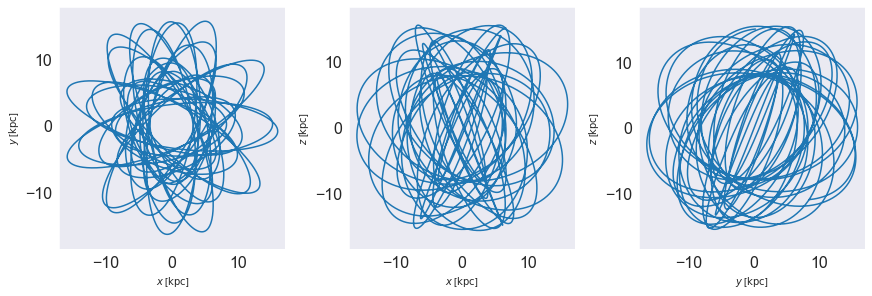

In [8]:
#integrate this in time
_= pal5.plot()

In [9]:
def read_stream_file(filename):
    """
    reads in a saved stream run 
    returns the subhalo, progenitor and stream
    """
    print (filename)
    f = h5py.File(path_data+'/'+filename, mode='r')
    
    body=f['nbody']
    stream_cont=f['stream']
    return body, stream_cont

In [10]:
filename=path_data+'/pal5_stream.h5'

In [11]:
#use mockstream see integrate it back 1 Gyr
mstream=3e4*u.Msun
time_dict_stream={ 'dt':-1*u.Myr, 't1':0.*u.Myr, 't2':-1.0*u.Gyr}
df = ms.FardalStreamDF()
prog_mass = mstream* u.Msun
gen = ms.MockStreamGenerator(df, H)
mock_st, mock_pos=gen.run(st_pos, mstream, **time_dict_stream, nbody=None, \
                          output_every=1, output_filename=filename,\
                          check_filesize=True,n_particles=1, progress=True, overwrite=True)

Integrating orbits:  100%

In [12]:
mock_icrs=mock_st.to_coord_frame(astro_coord.ICRS)

/opt/anaconda3/lib/python3.8/site-packages/astropy/coordinates/baseframe.py:1207: AstropyDeprecationWarning: Transforming a frame instance to a frame class (as opposed to another frame instance) will not be supported in the future.  Either explicitly instantiate the target frame, or first convert the source frame instance to a `astropy.coordinates.SkyCoord` and use its `transform_to()` method.
  warnings.warn("Transforming a frame instance to a frame class (as opposed to another "



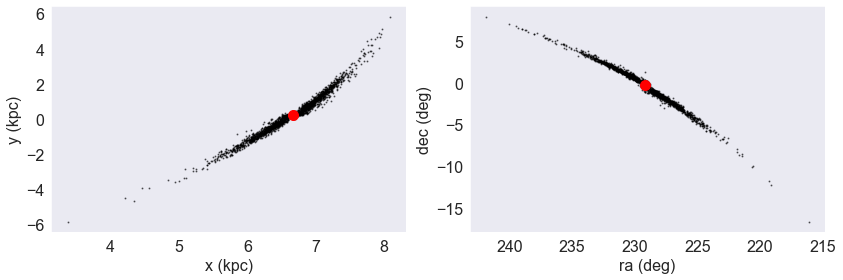

In [13]:
plot_stream(mock_st, mock_pos)

In [14]:
#get mock st position at t= -1Gyr
bd_all, st_all=read_stream_file('pal5_stream.h5')

pal5_stream.h5


In [15]:
st_pos_1Gyr_back=gd.PhaseSpacePosition(pos=(bd_all['pos'][:, :,0][:,0]).flatten()*u.kpc, \
                                       vel=(bd_all['vel'][:, :,0][:,0]).flatten()*u.kpc/u.Myr)

In [16]:
print ('satellite 1 Gyr ago{}'.format(st_pos_1Gyr_back.xyz.flatten()))
print ('satellite today {}'.format(st_pos.xyz.flatten()))

satellite 1 Gyr ago[ -5.72253558 -10.72759744   5.07473961] kpc
satellite today [ 6.66181308  0.21694083 15.05359637] kpc


In [17]:
#pick the collision to be at the center
halo_xyz= st_pos.xyz.flatten()*u.kpc
halo_vxyz=[0, 0, -300]*u.km/u.s
#halo_vxyz=(bd_all['vel'][:, :,0][:,0]).flatten()*u.kpc/u.Myr
halo_pos=gd.PhaseSpacePosition(pos=halo_xyz, vel=halo_vxyz)
#integrate back
halo_orbit=gp.Hamiltonian(pot).integrate_orbit(halo_pos, dt=-1*u.Myr, t1=0.*u.Myr, t2=-1.0*u.Gyr)
#halo_at_zero=gd.PhaseSpacePosition

In [18]:
print ('halo 1 Gyr ago{}'.format(halo_orbit[-1].xyz))
print ('halo today {}'.format(halo_pos.xyz))

halo 1 Gyr ago[ 39.47916793   1.2856325  -16.47661985] kpc
halo today [ 6.66181308  0.21694083 15.05359637] kpc2


In [19]:
halo_1Gyr_back_ps= gd.PhaseSpacePosition(pos=halo_orbit[-1].xyz, vel=halo_orbit[-1].v_xyz)
st_1Gyr_back_ps= gd.PhaseSpacePosition(pos=st_pos_1Gyr_back.xyz.flatten(), vel=st_pos_1Gyr_back.v_xyz.flatten())

In [20]:
#integrate both in time
comb_pos=gd.combine([halo_1Gyr_back_ps, st_1Gyr_back_ps])
                               

In [21]:
tmax= 1.01*u.Gyr

In [22]:
time_dict_for={ 'dt':1*u.Myr, 't1':0.*u.Myr, 't2': tmax}

In [23]:
comb_orbit=gp.Hamiltonian(pot).integrate_orbit(comb_pos, **time_dict_for)

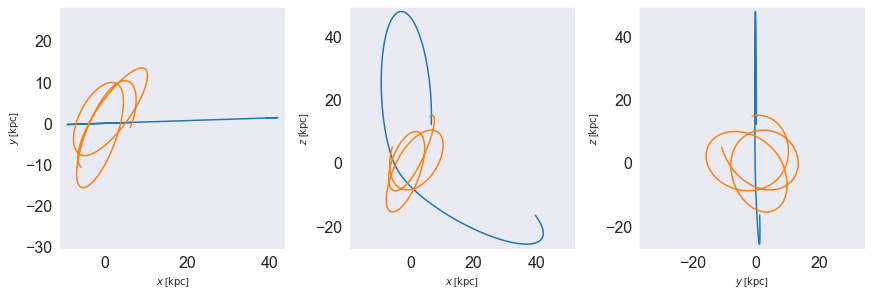

In [24]:
_= comb_orbit.plot()


In [25]:
hjkl

NameError: name 'hjkl' is not defined

In [ ]:
d=((comb_orbit[:,0].x-comb_orbit[:,1].x)**2+\
(comb_orbit[:,0].y-comb_orbit[:,1].y)**2+\
(comb_orbit[:,0].z-comb_orbit[:,1].z)**2)**0.5

In [ ]:
d.min()

In [ ]:
fig, ax=plt.subplots(figsize=(10, 6))
plt.plot(comb_orbit.t, np.log10(d.to(u.pc).value))
ax.set_ylabel('Log abs (halo-stream) (pc) ', fontsize=16)
ax.set_xlabel('time (Myr)', fontsize=16)
plt.savefig(path_plot+'/collision_orbits_history.jpeg')


In [ ]:
#%matplotlib notebook
fig, anim = comb_orbit.animate(stride=10, 
                           FuncAnimation_kwargs=dict(interval=2), marker_style={'ms':20})


In [ ]:
anim.save(path_plot+'/collision_orbits.gif', dpi=80, writer='imagemagick')

In [ ]:
1000/(100*100)

In [ ]:
st_pos = gd.PhaseSpacePosition(pos=[10., 0., 0.] * u.kpc,
                                vel=[0, 170, 0.] * u.km/u.s)

In [ ]:
c=st_pos.to_coord_frame(galcen_frame)

In [ ]:
bodies, stream=bd_all, st_all
body0=bodies['pos'][:,:,0 ]
#body1=bodies['pos'][:,:,1 ]

d=((  body0[0]-  (st_all['pos'][0]).T)**2+\
(  body0[1]-  (st_all['pos'][1]).T)**2+\
(  body0[-1]-  (st_all['pos'][-1]).T)**2)**0.5

print ('----------------minimum distance {} kpc---------'.format(np.nanmin(d)))

fig, ax=plt.subplots(figsize=(10, 6))
plt.plot(np.arange(len(d)), np.log10(d*1000))
ax.set_ylabel('Log abs (halo-stream) (pc) ', fontsize=16)
ax.set_xlabel('timestep ', fontsize=16)


In [ ]:
np.shape(st_all['pos'][0])

In [ ]:
np.shape(bd_all['pos'])

In [ ]:
np.shape()bd_all['pos'][:,:,0 ][0]-(st_all['pos'][0]).T